In [1]:
import torch 
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [3]:
bs = 128
in_dim=784
hid_dim = 256
out_dim=10

xbatch = torch.randn(bs, in_dim)
ybatch = torch.randint(low=0, high=10, size=(bs, ))

In [4]:
# Weights: 

# Layer 1: (no need for bias because batch norm after)
W1 = torch.randn(in_dim, hid_dim) / in_dim**0.5
#BatchNorm:
bngain = torch.randn(1, hid_dim)*0.1 + 1
bnbias = torch.randn(1, hid_dim)*0.1
# Layer 2:
W2 = torch.randn(hid_dim, out_dim) / hid_dim**0.5
b2 = torch.randn(out_dim)

parameters = [W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [5]:
# Forward Pass
n = xbatch.size(0)
# Layer 1:
hprebn = xbatch @ W1
## start batchnorm
bnmean = 1/n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmean
bndiff2 = bndiff**2
bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim=True) # Bessel's correction
bnvar_inv = (bnvar + 1e-5)**-.5
bnraw = bndiff*bnvar_inv
hpreact = bngain*bnraw + bnbias
## end batchnorm
h = torch.tanh(hpreact)

# Layer 2:
logits = h @ W2 + b2

# Softmax: :
logits_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logits_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts*counts_sum_inv

# Loss :
logprobs = probs.log()
loss = - logprobs[range(n), ybatch].mean()

for p in parameters: # Set all gradient to 0
    p.grad=None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logits_maxes, logits, h, hpreact, 
          bnraw, bnvar_inv, bnvar, bndiff2, bndiff, bnmean, hprebn]:
    t.retain_grad()
loss.backward()
print(loss) # shouls be close to -log(1/10)=2.3026

tensor(2.7566, grad_fn=<NegBackward0>)


In [6]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), ybatch] = -1/n
dprobs = probs**-1 * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = -counts_sum**-2 * dcounts_sum_inv
dcounts+=dcounts_sum
dnorm_logits = norm_logits.exp() * dcounts
dlogits_maxes = - dnorm_logits.sum(1, keepdim=True)
dlogits = dnorm_logits.clone()
matrix = torch.zeros_like(logits)
indices = logits.max(1, keepdim=True).indices
matrix[indices]=1
dlogits += matrix * dlogits_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1 - h**2)*dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar = -.5 * (bnvar + 1e-5)**-1.5 * dbnvar_inv
dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar 
dbndiff+=2*bndiff*dbndiff2
dhprebn = dbndiff.clone()
dbnmean = - dbndiff.sum(0, keepdim=True)
dhprebn += 1/n * torch.ones_like(hprebn) * dbnmean
dW1 = xbatch.T @ dhprebn

cmp('logprob', dlogprobs, logprobs)
cmp('prob', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts', dcounts, counts)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logits_maxes', dlogits_maxes, logits_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bndiff', dbndiff, bndiff)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('hprebn', dhprebn, hprebn)
cmp('bnmean', dbnmean, bnmean)
cmp('hprebn', dhprebn, hprebn)
cmp('W1', dW1, W1)

logprob         | exact: True  | approximate: True  | maxdiff: 0.0
prob            | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logits_maxes    | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
h               | exact: False | approximate: True  | maxdiff: 9.89530235528946e-10
W2              | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
b2              | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
hpreact         | exact: False | approximate: True  | maxdiff: 8.731149137020111e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.1641532182693481e-09
bnraw           | e

In [7]:
trainset = MNIST(root="../Datasets", transform=ToTensor(), train=True)
testset = MNIST(root="../Datasets", transform=ToTensor(), train=False)

In [8]:
# Weights: 

# Layer 1: (no need for bias because batch norm after)
W1 = torch.randn(in_dim, hid_dim) / in_dim**0.5
#BatchNorm:
bngain = torch.randn(1, hid_dim)*0.1 + 1
bnbias = torch.randn(1, hid_dim)*0.1
# Layer 2:
W2 = torch.randn(hid_dim, out_dim) / hid_dim**0.5
b2 = torch.randn(out_dim)

parameters = [W1, W2, b2, bngain, bnbias]

2.917659044265747
0.3525272011756897
0.3348829746246338
0.2837667763233185
0.3832002282142639
0.3575873076915741
0.311936616897583
0.21101152896881104
0.1932484656572342
0.2340933382511139


Text(0.5, 1.0, 'Loss evolution')

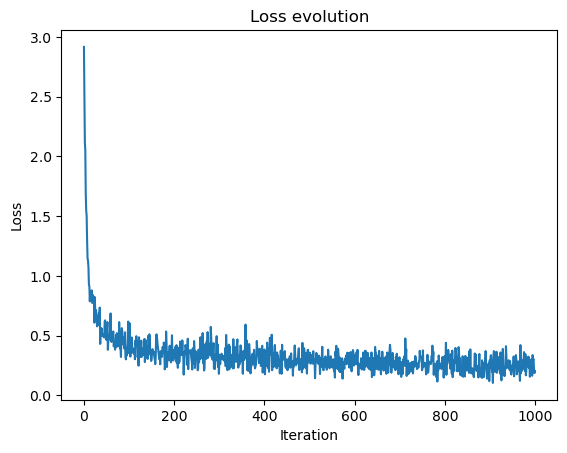

In [9]:
max_steps=1000
lr=5e-2
losses=[]

# Batch Norm Running Mean and Var
momentum=0.1
running_mean = torch.zeros(hid_dim)
running_var = torch.ones(hid_dim)

with torch.no_grad():
    for i in range(max_steps):
        idxs = torch.randint(len(trainset), (bs,))
        x, label = torch.stack([trainset[i][0] for i in idxs]), torch.tensor([trainset[i][1] for i in idxs])

        x = x.view(-1, 784)

        # Forward Pass : 
        n = x.size(0)
        ## Layer 1:
        hprebn = x @ W1
        ### start batchnorm
        bnmean = 1/n * hprebn.sum(0, keepdim=True)
        bndiff = hprebn - bnmean
        bndiff2 = bndiff**2
        bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim=True) # Bessel's correction
        bnvar_inv = (bnvar + 1e-5)**-.5
        bnraw = bndiff*bnvar_inv
        hpreact = bngain*bnraw + bnbias
        ### end batchnorm
        h = torch.tanh(hpreact)

        ## Layer 2:
        logits = h @ W2 + b2

        ## Softmax: :
        logits_maxes = logits.max(1, keepdim=True).values
        norm_logits = logits - logits_maxes
        counts = norm_logits.exp()
        counts_sum = counts.sum(1, keepdim=True)
        counts_sum_inv = counts_sum**-1
        probs = counts*counts_sum_inv

        ## Loss :
        logprobs = probs.log()
        loss = - logprobs[range(n), label].mean()
        losses.append(loss.item())

        ## Update Batch Norm running Mean and Var
        running_mean = (1-momentum)*running_mean + momentum*bnmean
        running_var = (1-momentum)*running_var + momentum*bnvar

        # Backprop : 

        dlogprobs = torch.zeros_like(logprobs)
        dlogprobs[range(n), label] = -1/n
        dprobs = probs**-1 * dlogprobs
        dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
        dcounts = counts_sum_inv * dprobs
        dcounts_sum = -counts_sum**-2 * dcounts_sum_inv
        dcounts+=dcounts_sum
        dnorm_logits = norm_logits.exp() * dcounts
        dlogits_maxes = - dnorm_logits.sum(1, keepdim=True)
        dlogits = dnorm_logits.clone()
        matrix = torch.zeros_like(logits)
        indices = logits.max(1, keepdim=True).indices
        matrix[indices]=1
        dlogits += matrix * dlogits_maxes
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        dhpreact = (1 - h**2)*dh
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnraw = bngain * dhpreact
        dbnbias = dhpreact.sum(0, keepdim=True)
        dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)
        dbndiff = bnvar_inv * dbnraw
        dbnvar = -.5 * (bnvar + 1e-5)**-1.5 * dbnvar_inv
        dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar 
        dbndiff+=2*bndiff*dbndiff2
        dhprebn = dbndiff.clone()
        dbnmean = - dbndiff.sum(0, keepdim=True)
        dhprebn += 1/n * torch.ones_like(hprebn) * dbnmean
        dW1 = x.T @ dhprebn

        grads = [dW1, dW2, db2, dbngain, dbnbias]
        for p, grad in zip(parameters, grads):
            p.data += - lr*grad
        
        if i % 100 == 0: # print every once in a while
            print(loss.item())
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss evolution')


In [10]:
all_preds = []
all_labels = []

with torch.no_grad():
    for x, label in testset:
        x = x.view(-1, 784)

        # Forward Pass : 
        n = x.size(0)
        ## Layer 1:
        hprebn = x @ W1
        ### start batchnorm
        bndiff = hprebn - running_mean
        bnvar_inv = (running_var)**-.5
        bnraw = bndiff*bnvar_inv
        hpreact = bngain*bnraw + bnbias
        ### end batchnorm
        h = torch.tanh(hpreact)

        ## Layer 2:
        logits = h @ W2 + b2

        ## Softmax: :
        logits_maxes = logits.max(1, keepdim=True).values
        norm_logits = logits - logits_maxes
        counts = norm_logits.exp()
        counts_sum = counts.sum(1, keepdim=True)
        counts_sum_inv = counts_sum**-1
        probs = counts*counts_sum_inv
        pred = torch.argmax(probs)
        all_preds.append(pred)
        all_labels.append(label)

all_preds = torch.stack(all_preds)
print(f"Accuracy: {accuracy_score(all_labels, all_preds)}")

Accuracy: 0.9315
